In [1]:
import os
import torch
import random
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
if not (os.path.exists('/content/ijcnlp_dailydialog.zip') and os.path.exists('/content/ijcnlp_dailydialog')):
  print('dowloading...')
  !wget http://yanran.li/files/ijcnlp_dailydialog.zip
  !unzip /content/ijcnlp_dailydialog.zip
else:
  print('files already exists')

if not (os.path.exists('/content/data/test') and os.path.exists('/content/data/train') and os.path.exists('/content/data/validation')):
  !mkdir data
  !unzip /content/ijcnlp_dailydialog/validation.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/train.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/test.zip -d /content/data
else:
  print('files already exists')

!rm /content/ijcnlp_dailydialog.zip
!rm -r /content/ijcnlp_dailydialog

clear_output(wait=False)

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace  # Correct import for Whitespace
from tokenizers.trainers import WordLevelTrainer

# Path to the dataset
path = "/content/data/train/dialogues_train.txt"
validation_path = "/content/data/validation/dialogues_validation.txt"
# Initialize the tokenizer with the WordLevel model
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()  # Ensure it tokenizes on whitespace

# Define the trainer with the specification for special tokens
trainer = WordLevelTrainer(special_tokens=["[UNK]"])

# Train the tokenizer
tokenizer.train(files=[path], trainer=trainer)
vocabsize = tokenizer.get_vocab_size()

print("Vocabulary size:", vocabsize)

# Test decoding some tokens
print(tokenizer.decode([1, 2, 3, 4, 5, 6]))

Vocabulary size: 20691
. __eou__ , I you ?


In [4]:
class CustomDataset():

    def __init__(self, data_path, tokenizer, batchsize, maxlength) -> None:
        self.data = open(data_path)
        self.tokenizer = tokenizer
        self.batchsize = batchsize
        self.maxlength = maxlength
        self.data = self.custom_dataset()


    def custom_dataset(self):
        data = []
        for line in self.data:
            seqs = line.split('__eou__')
            seqs = ''.join(seqs)
            data.append(seqs)
        self.length = len(data)//self.batchsize
        return data


    def __len__(self):
        return self.length


    def batch_tokenize(self, texts):
        token_ids_batch, token_mask_batch = [], []
        # add start token
        for text in texts:
            encoded = self.tokenizer.encode(text)
            if len(encoded) >= 64:
                token_ids_batch.append(encoded.ids)
                token_mask_batch.append(encoded.attention_mask)

        # Pad the sequences
        padded_ids_batch = [
            ids if len(ids) < self.maxlength else ids[:self.maxlength]
            for ids in token_ids_batch
        ]
        # Pad the masks
        padded_mask_batch = [
            mask if len(mask) < self.maxlength else mask[:self.maxlength]
            for mask in token_mask_batch
        ]
        return torch.tensor(padded_ids_batch), torch.tensor(padded_mask_batch)


    def load_batch(self, shuffle=True):
        data = self.custom_dataset()
        if shuffle:
            random.shuffle(data)

        for i in range(0, len(data), self.batchsize):

            batch_texts = data[i:i+self.batchsize]
            yield self.batch_tokenize(batch_texts)


# dataset = CustomDataset(path, tokenizer, batchsize=32, maxlength=128)
# for token_ids, token_masks in dataset.load_batch():
#     print(token_ids, token_masks)
#     break

In [5]:
import torch
import torch.nn as nn

import torch.nn.functional as F

from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
class EmbeddingLayer(nn.Module):
    def __init__(self, d_model, vocab_size, max_lens, device="cuda", dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout_layer = nn.Dropout(dropout)
        self.embedding_layer = nn.Embedding(vocab_size, d_model)
        self.positional_enoc = nn.Parameter(torch.zeros(1, max_lens, d_model)).to(device)

    def forward(self, x):
        embedding = self.layer_norm(self.embedding_layer(x))
        return self.dropout_layer(embedding + self.positional_enoc[:, :x.size(1), :])


class Vanilla_Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens, device="cuda", dropout=0.1) -> None:
        super().__init__()
        self.embedding_layer = EmbeddingLayer(d_model, vocab_size, max_lens, device)
        encoder_layer = TransformerEncoderLayer(d_model, n_head, dim_feedforward, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout_layer = nn.Dropout(dropout)
        self.device = device

    def get_causal_mask(self, seq_len, device):
        return Transformer.generate_square_subsequent_mask(sz=seq_len, device=device)

    def forward(self, x, src_padding_mask=None):
        embedding = self.embedding_layer(x)
        mask = self.get_causal_mask(x.size(1), device=self.device)
        encoded_embedding = self.encoder(src=embedding, mask=mask,
                          src_key_padding_mask=src_padding_mask, is_causal=True)
        output = self.output_layer(encoded_embedding)
        return self.dropout_layer(output)


In [7]:
src = torch.tensor([[0, 1, 2, 3, 4]]).to(device)
tgt = torch.tensor([[1, 2, 3, 4, 5]]).to(device)

vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens = vocabsize, 512, 8, 2048, 4, 64
model = Vanilla_Transformer(vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens).to(device)

In [10]:
import math
def validation(model, dataset, criterion):
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        total_token = 0
        for token_ids, token_masks in tqdm(dataset.load_batch(), total=dataset.length, leave=False):
            tokens = token_ids.to(device)
            masks = token_masks.to(device)
            for j in range(2):
                src = tokens[:, j*31:(j+1)*31]
                tgt = tokens[:, j*31+1:(j+1)*31+1]
                output = model(src)
                loss = criterion(output.transpose(1,2), tgt)
                epoch_loss += loss.item() * 32
                total_token += 32
        epoch_loss = epoch_loss/total_token
    return math.exp(epoch_loss)

In [11]:

epoch = 80
step_size = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
dataset = CustomDataset(path, tokenizer, batchsize=512, maxlength=64)
validationset = CustomDataset(validation_path, tokenizer, batchsize=32, maxlength=64)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.001)
# please exploring these parameters: epoch, lr, scheduler(step_size, gamma), (num_layer, d_model, n_head, dim_feedforward), batch_size
# size of (num_layer=6, d_model=512, n_head=8, dim_feedforward=2048)->153 MB, please don't test model larger than this one
train_loss = []
valid_loss = []
for i in range(epoch):
    e_loss = 0
    model.train()
    for token_ids, token_masks in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
        tokens = token_ids.to(device)
        masks = token_masks.to(device)
        for j in range(2):
            optimizer.zero_grad()
            src = tokens[:, j*31:(j+1)*31]
            tgt = tokens[:, j*31+1:(j+1)*31+1]
            output = model(src)
            loss = criterion(output.transpose(1,2), tgt)
            loss.backward()
            optimizer.step()
            e_loss += loss.item()
    e_loss = e_loss/(dataset.length*2)
    v_loss = validation(model, validationset, criterion)
    print(e_loss)
    print(v_loss)
    # print(tgt[0])
    # print(torch.argmax(output, dim=-1)[0])
    print('tgts: {}'.format(tokenizer.decode(tgt[0].tolist())))
    print('pred: {}'.format(tokenizer.decode(torch.argmax(output, dim=-1)[0].tolist())))
    print("epoch: {}".format(i))
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i + 1}, Current Learning Rate: {current_lr}")
    train_loss.append(e_loss)
    valid_loss.append(v_loss)
    scheduler.step(v_loss)


22it [00:34,  1.59s/it]


5.466620592843919
81.55410828077493
tgts: ' t we grab a bite to eat and do some catching up ? Yeah , why not ? I ' ve got a little free time on my hands .
pred: ' t know have that little . go . get . money . . Yes , I are . I ' ve got a lot bit . . the own .
epoch: 0
Epoch 1, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


4.920154310408092
61.002528516607
tgts: How might you spend the weekend . I hope to do a little gardening . I find it very relaxing . I might do that too . I hope the weather
pred: I do be have your bus ? I ' it get you lot longer . I ' it . much . I ' be that . . I ' you first
epoch: 1
Epoch 2, Current Learning Rate: 0.001


22it [00:33,  1.55s/it]


4.587539252780733
51.37973674556531
tgts: the net . You use the internet a lot , don ’ t you ? Yes . I use it to find products and components at the lowest price for my
pred: . street . I ' the same . lot of and ' t you ? Yes , I ’ the . the it . then . all same . . the
epoch: 2
Epoch 3, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


4.330751004673186
45.345098226686524
tgts: the one . ... Thank you . It ′ s a state - of - the - art piece of equipment , sir . With a gigantic 16 . 1 USGA
pred: a right of I I you . It ' a a very - time - time world five - - the , but . I it - , . I ,
epoch: 3
Epoch 4, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


4.089603043737865
41.58141487808369
tgts: back aches . I ' ll take your temperature . How long have you been feeling ill ? It began the night before last . You have a temperature , but
pred: god . ! I ' m take it room . Here long will you been ? ? ? I ' the next . ? night I can to few . but
epoch: 4
Epoch 5, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


3.869826453072684
38.9254830170718
tgts: I supposed to cook ? What do you feel like having ? I want some chicken and potatoes . That sounds really good . When are you going to make it
pred: sorry have to speak with What can you want like to to I don to things salads I . What ' good good . What I you going to do a
epoch: 5
Epoch 6, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


3.65561314423879
37.230708124652985
tgts: records in business . Second , I want to enter the foreign trade field . What was your chief responsibility in your past work ? I am in charge of marketing
pred: . for the . What , I have to be the UK trade with . I do your major responsibility in your last job ? I was afraid the of the
epoch: 6
Epoch 7, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


3.4575523762475875
36.472201639172575
tgts: sightseeing before I head back home . What do you suggest I see when I ' m here ? There are many interesting places you should be sure to see .
pred: of . . have . . . What do you want ? take , you get s going ? I ' two different . of can be the . do ,
epoch: 7
Epoch 8, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


3.286161876860119
36.313915164021275
tgts: , thank you . I think I can handle it . Well , if you change your mind , let me know . I will . Thanks . That ' s
pred: , it you for I ' I should afford it . I , let you have your mind , let me know . I ' . I a It ' s
epoch: 8
Epoch 9, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


3.136616133508228
35.6686662220148
tgts: one ? A single room , preferably with a bath . How long do you plan to stay ? For a week or so . You can have a room on
pred: one thing Sense single room with preferably with a bath . How long is you have to check ? A a minute , a . I can take to minute with
epoch: 9
Epoch 10, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


2.99143431867872
35.764431485057244
tgts: married soon . Have they set a date for the wedding ? No , not yet . But Susan says they ’ d like to get married in November or December
pred: in . . I you got a date for our wedding ? They , they yet . So I says that ' ll like to come married . November or December
epoch: 10
Epoch 11, Current Learning Rate: 0.001


22it [00:34,  1.56s/it]


2.8733956757045926
35.663964311240285
tgts: ’ s invited a lot of people . Do you think everyone will be able to get into her house ? If everyone turned up , it would be a squeeze
pred: ’ s a a lot of her . Really I know she will be able to get into her office ? She you , up , it is be a lot
epoch: 11
Epoch 12, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


2.75361434618632
35.820655278764136
tgts: shared her recipes with me . I especially like the wonderful chicken dish . That is a special coconut ginger chicken with rice dish . Is that shrimp in the soup
pred: shared her recipes with me . I ' love the girl chicken dish , It is really big coconut ginger chicken with rice dish or It there shrimp with this kitchen
epoch: 12
Epoch 13, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


2.647546824954805
37.215221866866074
tgts: service ? I don ' t need the full service . But the full service will make your nails look much prettier and it is on discount now . No ,
pred: of . I ' ' t know any full name . What I full address of be a full , . prettier . the is over me now ; Can ,
epoch: 13
Epoch 14, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


2.5574214912596203
37.68487228004133
tgts: . I did not know that . I ' m going to give you a ticket . Why can ' t you just let me off with a warning ? It
pred: . I didn . have that , I ' m going to stay it the break . I don ' son you a stand you a the it warning ? I
epoch: 14
Epoch 15, Current Learning Rate: 0.001


22it [00:34,  1.55s/it]


2.4741203614643643
40.07955220051682
tgts: This way , please . Thanks . You ' re welcome . Can we see the menu , please ? I ' ll bring it over . Anything good for this
pred: I pair , I ... I . I have ll welcome . Thank I have a menu , please , Sure ' ll go it over . How else for you
epoch: 15
Epoch 16, Current Learning Rate: 0.001


22it [00:33,  1.54s/it]


2.2173981354350136
41.58735520671943
tgts: then . Say it . Oh , really , Mark . I promise I ' m not going to be angry . Now why were you late ? I forgot .
pred: the . Say it . Oh , really , Mark . Never promise I ' m not going to . angry . I why were you late ? I forgot .
epoch: 16
Epoch 17, Current Learning Rate: 0.0002


22it [00:34,  1.55s/it]


2.1007501795178367
37.479584862053656
tgts: . May I have your room number ? My room number is 1010 and the name is Ted Black . Right , just wait a minute . I will get your
pred: . I I help your room number , My room wouldn is 1010 and there name is Ted Black . I now please a a minute . I ' check one
epoch: 17
Epoch 18, Current Learning Rate: 0.0002


22it [00:33,  1.54s/it]


2.0421543632234846
38.81338637531845
tgts: . F . Rangoon . Please let us know the quantity required so that we can work out the premium and freight charges . I ’ m going to place a
pred: ' F . Rangoon . Rangoon go me have the quantity required so we we can work . the premium for freight charges . I am m sorry to ask a
epoch: 18
Epoch 19, Current Learning Rate: 0.0002


22it [00:34,  1.56s/it]


2.00341082186926
40.01970099715178
tgts: make fool yourself . You look stupid in that robe . What ? But it is my favorite piece of clothing . Maybe it is . But it ’ s out
pred: miss it yourself . You look stupid in that house . What ? But it is the favorite piece of clothing . Maybe it is . But it is , out
epoch: 19
Epoch 20, Current Learning Rate: 0.0002


22it [00:34,  1.55s/it]


1.9640761046182542
39.78537983124676
tgts: have a baby . Actually they ’ re expecting the baby to come on my birthday . Oh , what a coincidence ! I bet Bobby must be very happy about
pred: think any baby . Come they ’ re expecting the baby to come on . birthday . Oh , that a coincidence ! I bet Bobby must be very late about
epoch: 20
Epoch 21, Current Learning Rate: 0.0002


22it [00:34,  1.55s/it]


1.9253803548358737
38.69478193402369
tgts: is so cool . Let ' s rock and roll ! OK . Relax . This car is an automatic , so you don ' t have to worry about a
pred: is my good . I ' ! play and roll ! OK . Relax . What stupid park an automatic , we you ' ' t have to pay about going
epoch: 21
Epoch 22, Current Learning Rate: 0.0002


22it [00:33,  1.54s/it]


1.8811209003130596
39.89753155389323
tgts: aren ' t you ? Yes , I ’ m going to take a holiday tomorrow . How nice ! I can see you are busying packing . I ' m
pred: I ' t you . Yes , I ' Ve learning to try a holiday tomorrow . How nice to I can see you are busying packing . I have m
epoch: 22
Epoch 23, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.8693611110959734
39.48883367003743
tgts: the top , Mr . Thomas , the managing director , is responsible for running the company . How many departments do we have ? Four . They are production department
pred: the top , the . Thomas , the managing director , is responsible for the the company . How many departments do we have ? Four . They are production department
epoch: 23
Epoch 24, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.863296579746973
40.4344464630359
tgts: else takes its place , like work ? Yes , so this year we are going to take our first family vacation , just you and I . And where are
pred: valuable in its place , so ... ? Yes , I the year I have going to the our vacation trip reunion , but to . I will I where are
epoch: 24
Epoch 25, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.8562632089569455
41.02476198494914
tgts: , I ' m fine now . Honey , have you ever heard that there are a lot of stray cats now . Yes . Now they are collected by some
pred: , so just ll fine now . Here , I you finished heard about you are many lot of stray cats now . Yes , What some ' collected by some
epoch: 25
Epoch 26, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.8488041900453114
39.76705125641718
tgts: you tell me how much I owe ? You owe $ 235 . 13 in fees . I can ’ t believe that . When will you be paying these fees
pred: you tell me something to I can ? You need $ 235 . 13 in fees . 50 don ’ my believe that . You will you be paying these fees
epoch: 26
Epoch 27, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.8322896843864804
40.76115332695102
tgts: . Here ' s my passport . what ' s the expiration date on your passport ? I think it ' s soon , maybe in a few months . It
pred: , Here ’ s my claim . Do ' s the expiration time on your passport ? I am it ' s soon , maybe in a few months . It
epoch: 27
Epoch 28, Current Learning Rate: 4e-05


22it [00:34,  1.55s/it]


1.821647788797106
40.88512527677796
tgts: got you these Easter lilies . They ' re beautiful . Taylor , you ' re so pale and skinny ! Of course I ' m pale . It ' s
pred: ' a through goods lilies . They ' ve beautiful ! Yes , and ' d playing pale and skinny ! I course I ' m pale . You ' s
epoch: 28
Epoch 29, Current Learning Rate: 8.000000000000001e-06


22it [00:34,  1.55s/it]


1.8158636064756484
40.95427651817974
tgts: been to a game for a few weeks . How ’ d it go ? Did we win ? Nope , lost again . But , it was a good game
pred: you it a , for a few days . I could d it go ? We you win ? Nope . do again I But , you ’ the good game
epoch: 29
Epoch 30, Current Learning Rate: 8.000000000000001e-06


22it [00:34,  1.55s/it]


1.823569377263387
42.15939741519108
tgts: , in fact , my mom ' s house we have three , three pets . two dogs and a cat . My family actually raises dogs for helping blind people
pred: . sir fact , we life has s house we have three pets three pets on two dogs and a cat . I family came raises dogs and helping blind people
epoch: 30
Epoch 31, Current Learning Rate: 8.000000000000001e-06


22it [00:34,  1.55s/it]


1.8255039339973813
40.26556575754846
tgts: that . But remind you , there are some forbidden activities . What are they ? I ’ ll be careful . Don ’ t use office phones for personal matters
pred: . . But remind you , I are some forbidden activities . What are the ? They ’ ll be careful . Don ’ t use office phones for personal matters
epoch: 31
Epoch 32, Current Learning Rate: 8.000000000000001e-06


22it [00:34,  1.55s/it]


1.8242675236293249
40.674396213388924
tgts: good . What part of the film do you like best ? Well , the scene of the hero ' s struggle with enemies impressed me the most . I loved
pred: a . Can part of the film do you like best ? I , the scene of the hero ' s struggle with the impressed me the hero . I loved
epoch: 32
Epoch 33, Current Learning Rate: 8.000000000000001e-06


22it [00:33,  1.54s/it]


1.8177347949572973
42.244334245372215
tgts: there any other cities where it ' s always hot ? Many . Most of the cities in the southern part of the United States are hot all year . But
pred: your any interesting cities where it ' s always hot ? Many ! Most of the cities do the United part of the United States are hot . year . But
epoch: 33
Epoch 34, Current Learning Rate: 8.000000000000001e-06


22it [00:34,  1.59s/it]


1.8194459279378254
40.095478909506376
tgts: It is not true . Look at my eyes . Well , I confess . I did it , because I urgently need money to buy some medicine for my mother
pred: I was really enough . But , the eyes . You , I confess , I confess not , too I urgently need money to buy some medicine for my father
epoch: 34
Epoch 35, Current Learning Rate: 1.6000000000000004e-06


22it [00:33,  1.54s/it]


1.8224501553035917
40.947416784396225
tgts: is very quiet . That is exactly what we ' re looking for . Well , each room is 40 dollars a week . That sounds all right to us .
pred: is very beautiful . That is exactly I we ' re looking for . Well , each team is 40 dollars a week . That ' all right to us .
epoch: 35
Epoch 36, Current Learning Rate: 1.6000000000000004e-06


22it [00:34,  1.55s/it]


1.8165888814699083
41.94066121298735
tgts: at once . No problem at all . With this service , you can pay up to 10 parties at one time . Are these parties on your current beneficiaries list
pred: at once , I problem at all . So this , , you can see up to get . at one time . Do there parties on the own beneficiaries list
epoch: 36
Epoch 37, Current Learning Rate: 1.6000000000000004e-06


22it [00:33,  1.54s/it]


1.82147916441872
39.71760746822813
tgts: don ' t you change the cash to traveler ' s checks ? It ' s much more convenient and safer . When you are abroad , you can cash them
pred: ? ' t you sit the cash to traveler ' s checks ? I ' s checks more convenient . safer . When do are making , you ' cash it
epoch: 37
Epoch 38, Current Learning Rate: 1.6000000000000004e-06


22it [00:34,  1.55s/it]


1.8148048293022883
40.07654211563305
tgts: . Put on something by the Backstreet Boys ! How about " As long as You Love Me " ! You can pretend you ' re singing it to your fiancee
pred: , Here on something by the Backstreet Boys ! How ' As As long as You Love Me ! ! You can pretend you ' re singing it to your fiancee
epoch: 38
Epoch 39, Current Learning Rate: 1.6000000000000004e-06


22it [00:34,  1.55s/it]


1.8093069678261167
40.16423510085885
tgts: home in Woodlawn . Congratulations ! That ’ s wonderful . I bet both of you are quite happy . Well , we have always dreamed of owning our own home
pred: student in Woodlawn . Congratulations ! That ' s great . I am both it you have quite happy . Well , what have always dreamed of owning our own home
epoch: 39
Epoch 40, Current Learning Rate: 1.6000000000000004e-06


22it [00:34,  1.55s/it]


1.815911664849236
40.49040731158934
tgts: Ve ever had . Why ? What happened ? Well . Mary had promised to be my date , but she stood me up . I waited for her for a
pred: m been thought . Yeah ? What happened ? The , It had promised to leave my date , but she stood me up . I waited for a . her
epoch: 40
Epoch 41, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.55s/it]


1.8181654044560023
40.12378877428211
tgts: you ' d like . I ' ll make a list . First , we need eggs , milk , and bread . Okay , do we need any meat ?
pred: you ' d like . I ' ll make a list . Let we we need eggs , milk , and a . Okay , well we need any meat ?
epoch: 41
Epoch 42, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.55s/it]


1.8049399966285342
40.61535023343398
tgts: English language websites every day and go to my local English Corner twice a week . Do you ever speak to native speakers of English ? Sadly , I hardly ever
pred: the language websites every and and I to my English English Corner twice a week . Me you know speak to native speakers ? English ? Sadly , I hardly ever
epoch: 42
Epoch 43, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.55s/it]


1.8154507251012892
41.70133138367443
tgts: home myself right now with nothing much to do . Me , too . What would you like to do ? Well , we could go to a movie . Have
pred: my with right now . nothing much . do . You , too . I do you like to do in Well , we could go to a movie . I
epoch: 43
Epoch 44, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.55s/it]


1.8081922701426916
41.77361675096618
tgts: OK . There was a lot of turbulence , though . That ’ s too bad . How long was the flight ? It was 10 hours . Did you have
pred: no . I was a big Did turbulence , though . That ’ s great bad ! What long would the weather ? It was 10 : , That you have
epoch: 44
Epoch 45, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.55s/it]


1.8165962383860634
41.74765359288265
tgts: ? I ' m afraid not . The tooth is too far gone . It ' ll have to be taken out . Then I might as well have it out
pred: . I ' m afraid not , The only is just far gone . I ' ll have them be taken out . You we ' as well ask it out
epoch: 45
Epoch 46, Current Learning Rate: 3.200000000000001e-07


22it [00:34,  1.56s/it]


1.812188744544983
40.00958670887529
tgts: more at my parents ' . Do you have a bed ? Of course , I have . There is one in my old house . And I have another one
pred: of . the parents ' . Me you have enough bed ? No father . I have . There ' no in my old house . How I have been one
epoch: 46
Epoch 47, Current Learning Rate: 6.400000000000003e-08


22it [00:34,  1.55s/it]


1.8163312276204426
41.819631491628805
tgts: the map . No , there aren ’ t . this map just show the geographical features . Look at the Himalayan plateau with the highest peaks in the world .
pred: the internet . No , I aren ’ t . this map just show the geographical features . Look at the highest . with you highest peaks in the world .
epoch: 47
Epoch 48, Current Learning Rate: 6.400000000000003e-08


22it [00:34,  1.55s/it]


1.814959588504973
40.18039349187531
tgts: structure for students ? Where is the parking structure at ? It ' s on the west side of the campus . Do you know if the parking structure is full
pred: structure for ? . It is the parking structure . the It ' s on the west side of the campus . Do you have if the parking structure is full
epoch: 48
Epoch 49, Current Learning Rate: 6.400000000000003e-08


22it [00:33,  1.54s/it]


1.8191318880944025
40.374888167218124
tgts: know , insomnia is usually caused by stress . Are you stressed at all ? well , I ' m really worried about my grades . I didn ' t think
pred: ' I insomnia is usually caused by stress . Are you stressed at all ? I , I think ve really interesting about my grades . I didn ' t know
epoch: 49
Epoch 50, Current Learning Rate: 6.400000000000003e-08


22it [00:33,  1.54s/it]


1.8211810503687178
40.27378184613822
tgts: a passbook . Is there any minimum for the first deposit ? No , Even a dollar is all right . Here ' s your passbook , sir , just sign
pred: . passbook . Will there anything special for a first deposit ? We , there a minimum is all right . Here you s your passbook , sir . sir a
epoch: 50
Epoch 51, Current Learning Rate: 6.400000000000003e-08


22it [00:33,  1.54s/it]


1.815461170105707
40.64294988565152
tgts: got you these Easter lilies . They ' re beautiful . Taylor , you ' re so pale and skinny ! Of course I ' m pale . It ' s
pred: ' a through Easter . . If ' re beautiful ! You , you ' re so pale and skinny ! Oh course I ' ll pale . Let ' s
epoch: 51
Epoch 52, Current Learning Rate: 6.400000000000003e-08


22it [00:33,  1.54s/it]


1.8116981188456218
40.62500548201704
tgts: don ' t . It is free of charge . Well , then , will you put this and that into doggie bags ? Certainly , would you wait for a
pred: know ' t stop I ' free of charge . That , then , will you put this and that . it bags ? Yes , I you wait for that
epoch: 52
Epoch 53, Current Learning Rate: 1.2800000000000007e-08


22it [00:33,  1.54s/it]


1.8146306162788755
40.818217296790316
tgts: for the damage . How much are you talking ? It ’ s going to be $ 5 . That ’ s not bad at all . It really isn ’
pred: for the damage . How much are you talking ? It ' , $ to be $ 5 . That ’ s a bad , the . I ’ a ’
epoch: 53
Epoch 54, Current Learning Rate: 1.2800000000000007e-08


22it [00:33,  1.54s/it]


1.8109830674670993
40.1458653954816
tgts: your account number ? 8902365 . And your address , please ? 845 lincoln Avenue . When do you want it cancelled ? Beginning the first day of next month .
pred: the account closed ? 8902365 . No the address , please ? 845 lincoln Avenue . I are you want it cancelled ? Beginning the first . of just month .
epoch: 54
Epoch 55, Current Learning Rate: 1.2800000000000007e-08


22it [00:33,  1.54s/it]


1.8164959720202856
39.620987850990154
tgts: ! Why so much ? I thought they were getting you an assistant . They were supposed to , but so far nobody ’ s turned up , and I ’
pred: , What so much ? I thought they were getting you an assistant . They were supposed to , but so far nobody ’ s turned up , and I spent
epoch: 55
Epoch 56, Current Learning Rate: 1.2800000000000007e-08


22it [00:33,  1.54s/it]


1.8112334325200035
40.72322362858746
tgts: am very sorry . When will it be working again ? It should be back on in the next couple of days . Do I still have to pay for the
pred: ' sorry interested for I will we be working again ? It ’ be back tomorrow the on middle Sunday of days . No I know have to pay for the
epoch: 56
Epoch 57, Current Learning Rate: 1.2800000000000007e-08


22it [00:33,  1.54s/it]


1.8208698289734977
41.193544294441985
tgts: maturity date yet , but it is an emergency . OK , can I see the note and some ID , please ? There you are . As you can see
pred: traffic date yet , I I is not emergency . Okay , I I take the note and then ID , this . Sure are here . How you know see
epoch: 57
Epoch 58, Current Learning Rate: 1.2800000000000007e-08


22it [00:34,  1.55s/it]


1.8167772037642342
40.60288984237893
tgts: the Internet . Can I go in to look for a job at their office ? That ’ s a good decision . They have many good job search tools there
pred: work best . How I take to to look for a job at the office ? Yes ’ ll a good job and They ’ a interesting job search , there
epoch: 58
Epoch 59, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8132840111142112
39.28843743180854
tgts: Tsingtao beer . But we ' ve can canceled one bottle . Oh , I ' m sorry . Let me go back to the cashier ' s to have it
pred: several beer . Let we can ve got canceled one bottle . Oh , I couldn m sorry . I me see back to the cashier ' s that have our
epoch: 59
Epoch 60, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8144843918936593
41.54785014325329
tgts: English in junior and senior high school . And in college , I took English conversation lessons . They were given by foreign tutors . Have you passed College English Test
pred: ? in junior and senior high school . And I the ? you took English conversation in . That were given by the tutors . Do you ever College English Test
epoch: 60
Epoch 61, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8175223838715326
41.62763412259086
tgts: . Sure it is . I am up to my ears as time expressed . Do we still use the conference room in the same hotel as last time ? You
pred: , Sure it is . I know not my my ears as time as . Um you still use the conference room in the last service as last time ? No
epoch: 61
Epoch 62, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8165843827383858
40.38671679554214
tgts: room hasn ' t been cleaned up yet . So would you send one of your housekeepers to clean up our room ? Oh , yes , ma ' am .
pred: new hasn ' t been cleaned up since . It would we send one of your housekeepers to clean up our room ? Oh , no . we ' am .
epoch: 62
Epoch 63, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8126701372010368
41.44139268391871
tgts: I was completely blown away by your strategy outline . I ' ve gotta say , Alex , you really wowed me today . Aw , come on ; it was
pred: I can just over away by your strategy outline . I ' ve gotta say , my , you really wowed you today . Aw , come to , did was
epoch: 63
Epoch 64, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8189677340643746
39.89705222538626
tgts: in the success of the plan were outstanding . I just did what I should have done . You ’ Ve got a great personality . Thank you for your compliments
pred: in our paper in the world ? outstanding . I ’ did it I should do done . I ’ Ve done a good apartments . We you , your compliments
epoch: 64
Epoch 65, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8119570158776783
40.79864080785743
tgts: can ring you up at the register over here . Great . Will you be paying by cash , check , or credit card ? I want to use a credit
pred: ' ' you lent by the register over here . Do . But you be paying by the or or , or credit card ? I want to send my check
epoch: 65
Epoch 66, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8188159125191825
41.12215821164579
tgts: get up at 7 : 15 , you can dial 100715 . OK . I understand . Or we can call you tomorrow coming . Well , I would prefer you
pred: go a in the : 15 , 000 can dial the . We . Do know . So you can ' you by morning at It , let am prefer you
epoch: 66
Epoch 67, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.821318751289731
41.097375697012616
tgts: her face . Actually , natural beauty comes from within . Ah , I can smell jealousy in the air . She has nothing that deserves my jealousy . I don
pred: then face when Oh , I beauty comes out all . Ah ... I haven ’ jealousy the . air . I has nothing but deserves the jealousy . What think
epoch: 67
Epoch 68, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8136416389828636
40.65372844973585
tgts: others ? This automobile is just right for your needs because not only is it compact for ease in city driving , but also , it has many safety features .
pred: list ? I automobile is just right for your father because the really for about compact for ease in the driving , but we , it has many safety features .
epoch: 68
Epoch 69, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.812404337383452
38.68509818721908
tgts: how about the Museum of Modern Art ? No , I don ' t like museums . They ' re boring . Why don ' t you go to see the
pred: here about the Museum of Modern Art Yes No , I don ' t like museums . They ' re boring . Why don ' t you like to see the
epoch: 69
Epoch 70, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.8099292119344075
40.269238697619606
tgts: . How about a nice shirt and tie ? You can ' t go wrong there . Well . He doesn ' t wear ties that often . We have some
pred: . I about a tie shirt or tie ? That can ' t get down there . Well . I is ' t wear ties that big . It can four
epoch: 70
Epoch 71, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8105687158448356
41.74951290133644
tgts: from you again . What can I do for you today ? We ' ll be coming in tomorrow to make a rather large cash withdrawal , it ' s for
pred: about you again . Is can I get for you today ? I ' d need in in tomorrow morning do a lot large birthday withdrawal . sir ' s our
epoch: 71
Epoch 72, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.8141147267250788
41.47175746607314
tgts: progress toward your educational goal . In order to do these wisely and effectively , you should consult with a Program Adviser or Academic Counselor . Wait a minute . There
pred: house prices your educational goal . In order to do these two and effectively are we should consult and us Program Adviser or Academic Counselor . There a minute . There
epoch: 72
Epoch 73, Current Learning Rate: 2.5600000000000015e-09


22it [00:33,  1.54s/it]


1.8173005297070457
41.99972660491876
tgts: you ' re playing sports . What else ? Using MP3 mode , you can download about 10 hours of music from either your CD player , or your computer '
pred: Alan ' re done sports . Yes do ? Using MP3 mode and you can help about 10 minutes of music from that your CD player , or your CD won
epoch: 73
Epoch 74, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.814104662055061
42.57623720452253
tgts: little of her . I only think she ’ s pretty and intelligent . Of course , she ’ s diligent , too . That ’ s enough for you to
pred: that of her . I just think she has s at and intelligent . You course , maybe ’ s diligent , because . I ’ s a for you to
epoch: 74
Epoch 75, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.8206580110958643
39.50425000019158
tgts: as waltz 、 rumba and so on . They are quite graceful . You are waltzing quite wonderfully . It ' s great to dance with a experience and talent partner
pred: a waltz 、 rumba and so early . They ' the graceful . The ' waltzing quite qualified . I ' s great to dance with a great and talent partner
epoch: 75
Epoch 76, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.8089577953020732
41.69678408379825
tgts: ’ Ve been out of town the last few days . What did you need ? Really , nothing big . I just heard about your ideas on employee motivation and
pred: am m just out of town the bank few days ! What are you say ? I , I big . I was got about your ideas on employee motivation and
epoch: 76
Epoch 77, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.8143139396395003
41.074456182524735
tgts: ' m afraid it ' s too hard to wash off the stain . It ' s no big deal . I really feel great shame . Let me buy a
pred: ' m afraid I ' s a hard to buy off your stain off It ' s no big deal . I ' don bad . . I me have a
epoch: 77
Epoch 78, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]


1.812784453233083
39.75746854366532
tgts: ' s name , the account number , the amount in the account and your PIN number , please ? Well , the account ' s in my name . Patrick
pred: ' re name , the account number , the account you the account number the PIN number , please ? Oh it since card will s in my account . Patrick
epoch: 78
Epoch 79, Current Learning Rate: 2.5600000000000015e-09


22it [00:34,  1.55s/it]
                                               

1.8174586324464708
40.44520318049017
tgts: washed . There is a laundry form in your room ars well as a bag . Fill out the form and put them together with the laundry in the bag .
pred: washed . OK are a stop form on your laundry ars well before a bag . Fill out the laundry and put them together with the bag are the laundry .
epoch: 79
Epoch 80, Current Learning Rate: 2.5600000000000015e-09


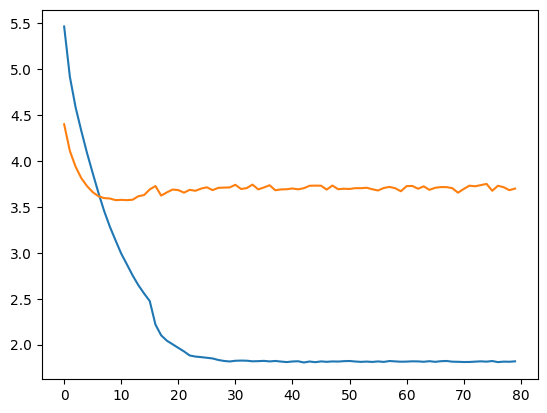

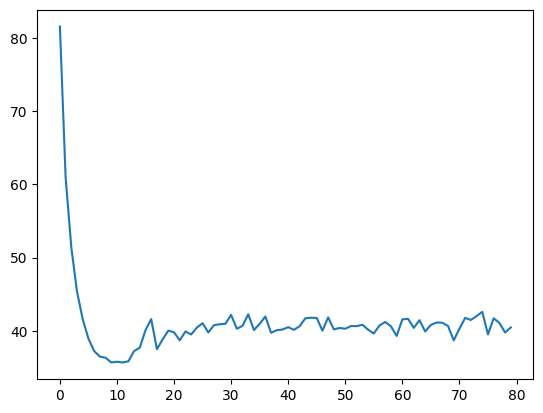

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot([math.log(i) for i in valid_loss])
plt.show()

plt.plot(valid_loss)
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/model")

In [ ]:
text = "do you want to go out?"
token = tokenizer.encode(text).ids
token = torch.tensor(token)
token = token.to(device)
token = token.unsqueeze(0)
pred_tokens = []
for i in range(10):
    output = model(token)
    pred = torch.argmax(output, dim=-1)
    pred_tokens.append(pred[:,-1])
    token = torch.cat([token, pred[:,-1].unsqueeze(0)], dim=1)

pred_text = tokenizer.decode(pred_tokens)
print(pred_text)

def inference_top_1(text, length):
    token = tokenizer.encode(text).ids
    token = torch.tensor(token)
    token = token.to(device)
    token = token.unsqueeze(0)
    pred_tokens = []
    for i in range(length):
        output = model(token)
        pred = torch.argmax(output, dim=-1)
        pred_tokens.append(pred[:,-1])
        token = torch.cat([token, pred[:,-1].unsqueeze(0)], dim=1)
    predict = tokenizer.decode(pred_tokens)
    print("input text: [{}]".format(text))
    print("next words prediction : [{}]".format(predict))
    return predict

def inference_top_k(text, length):
    while True:
        token = tokenizer.encode(text).ids
        token = torch.tensor(token)
        token = token.to(device)
        token = token.unsqueeze(0)
        pred_tokens = []

        for j in range(length):
            output = model(token)
            top_five_solutions = []
            top_five_indices = torch.topk(output, k=5, dim=-1)[1]
            print(top_five_indices.shape)
            for k in range(5):
                top_five_solutions.append(tokenizer.decode(top_five_indices[:,-1,k].tolist()))

            print("Top five predictions:")
            for i, solution in enumerate(top_five_solutions):
                print(f"{i+1}: {solution}")

            user_choice = input("Choose one of the predictions (1-5), or 6 to exit: ")

            if user_choice == '6':
                print("Exiting...")
                break

            try:
                choice_index = int(user_choice) - 1
                if 0 <= choice_index < 5:
                    selected_solution = top_five_solutions[choice_index]
                    print("Selected:", selected_solution)
                    text += " " + selected_solution
                    print(text)
                else:
                    print("Invalid choice. Please choose a number between 1 and 5.")
            except ValueError:
                print("Invalid input. Please enter a number between 1 and 5, or 'stop' to exit.")

            token = torch.cat([token, top_five_indices[:,:,choice_index]], dim=1)

    return text


predict = inference_top_1(text, length=10)
predict = inference_top_k(text, length=10)

In [14]:
!pip install modelsummary
clear_output(wait=False)

In [15]:
from modelsummary import summary
model.eval()
summary(model, torch.ones((1, 31), dtype=torch.long).to(device))

-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
         EmbeddingLayer-1                   [-1, 31]               0
              Embedding-2                   [-1, 31]      10,593,792
              LayerNorm-3              [-1, 31, 512]           1,024
                Dropout-4              [-1, 31, 512]               0
     TransformerEncoder-5                         ()               0
TransformerEncoderLayer-6              [-1, 31, 512]               0
     MultiheadAttention-7              [-1, 31, 512]               0
                Dropout-8              [-1, 31, 512]               0
              LayerNorm-9              [-1, 31, 512]           1,024
                Linear-10              [-1, 31, 512]       1,050,624
               Dropout-11             [-1, 31, 2048]               0
                Linear-12             [-1, 31, 2048]       1,049,088
               Dropout-13      